# CAB420, Neural Attention, Bonus Example: Visual Transformers
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* ~~There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.~~ Except there is here.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview
We've seen transformers used for text processing, which is what they were originally proposed for. However, they are becomming increasingly common for other tasks, including vision tasks.

The challenge in using a transformer for a vision task, in particular a task which operates over just a single image, is that the data isn't really a sequence - but we can make it one. By splitting an image into a sequence of patches, and obtaining an embedding per patch, we can get a representation that can be fed to a transformer. By virtue of the position embedding, we even retain some knowledge about where in the image the patch came from, allowing us to still leverage spatial information. 

It's worth considering the different between the spatial information captured by the transformer vs what happens with a DCNN. With a DCNN, our receptive field get's progressivley bigger as we go deeper into the network. Filters in shallow layers only see a very small part of the image, but by the time we get to the deeper layers the filter is effectivley able to see most (or even all) of the input frame.

With a transformer, the multi-head attention mechanism looks at each element in relation to all others. If each of our elements represents a small patch, the transformer layer will look at how each patch relates to each other patch. We can (kind-of) view this as the transformer layer having a receptive field across the entire image, and so there is the potential to capture relationships between distant spatial regions in much shallower networks.

At this we'll stop with the text and get into the code; though please note that this example is adapted from [here](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

### WARNING

**This example will not be quick to run if you don't have a GPU. Even if you do have a GPU, be careful with some of the parameters around network size - you may make things run very, very slowly.**

### Where does this fit into all the other CAB420 content?

First up, **this example really is getting well outside the scope of CAB420**.

If that first line didn't scare you off, this example is a an extension to the metric learning content which incorporates the idea of "self supervised learning" that we saw introduced with autoencoders. The content in here really is creeping well outside the scope of CAB420, you're very unlikely to have any reason to use this stuff in Assignment 2 for example, but it's (I think) interesting and another nice example of learning from no labels.

## Too Long; Didn't Read:
The main take home messages from this example are:
* Transformers are not just for things that are conventionally a sequence, we can make other things (like an image) into a sequence too.
* To do this, we need to break our image into regions, and get an emebdding per region. We can do this
  * with a dense layer (or layers), that takes a flattened image patch and encodes an embedding
  * with a small convolutional network, that extract CNN features for regions
* Our actual transformer is unchanged from what we used for text, it's just the way that we create the input emebeddngs that need to change
* Our visual transformers are not fast. While they can benefit to a very large degree from parallelisation, regular DCNNs can also get such benefits; that said, they do still work very well here.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf

import keras
from keras import layers
import matplotlib.pyplot as plt

## The Data

We're going to use CIFAR-100 here. This is very much like CIFAR-10, but now with 100 classes. The dataset is the same size (50,000 training images and 10,000 test images), so we have 10 times fewer example images per class.

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

## Network Parameters

Transformers can be big and slow. The following is a bunch of parameters you can use to tune the size of the network. Note that compared to the values used in the [original example](https://keras.io/examples/vision/image_classification_with_vision_transformer/), I've greatly downsized the network as that was very slow to run on my GPU desktop (which is getting old if I'm honest).

Feel free to tweak these values, but be mindful that if you're not careful, you'll get something that is very demanding to run.

In [3]:
## optimiser and training parameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100

## tranformer parameters
# input image size, the model will resize image to this size. Bigger images means more patches, which 
# means more fine-grained spatial relationships. Bigger images also means things get much slower
image_size = 32  # CIFAR-100 images are natively 32x32, I'm leaving that at this size
# patch size, how big is each "element" in our sequence? This should be a factor of the image size
patch_size = 8  # 8x8, we'll get 16 patches per image at a 32x32 image
# number of patches, derived from the above two parameters
num_patches = (image_size // patch_size) ** 2
# the embedding size we'll use for our patches. Each of our patches will be projected into something
# of this size. A bigger value will mean a richer representation (but slower)
projection_dim = 32
# number of attention heads
num_heads = 4
# size of the transfomer layer, note that there are two dense layers, the second of which is the same 
# size as the embedding
transformer_units = projection_dim * 2
# number of transformer layres
transformer_layers = 2
# size of the dense layers of classifier, i.e. after the transformers, prior to the final softmax layer
# for classification
mlp_head_units = [512, 256]  

## Data Augmentation

We have a fairly complex problem here: 100 classes, only 500 samples per class. Data augmentation is thus a good idea.

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Images as Sequences

Now we need to get our data into a format we can use for a sequence processing task. As noted above, we'll do this by splitting our image into patches. Just to make it more complex, we want to do this **inside** the network, i.e. we'll pass an image in, augment it, and then split it up. That means we need to wrap our splitting up in a layer.

In [5]:
# our patch splitting layer (note that this layer has no learned parameters).
class Patches(layers.Layer):
    # Initialise the layer.
    # params are:
    # - patch_size: the size of the patch we wish to extract
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    # Do a forward pass through the layer
    # params are:
    # - images: what we want to split into patches
    def call(self, images):
        # get the batch size
        batch_size = tf.shape(images)[0]
        # extract the patches. There's a tensorflow function for this exact
        # purpose, so just call that
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # package up the extracted patches in the correct shape
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        # return patches
        return patches

As always, we shoud check things work, so we'll visualise the patches.

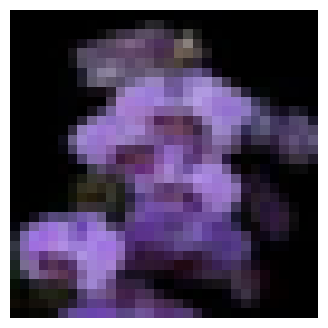

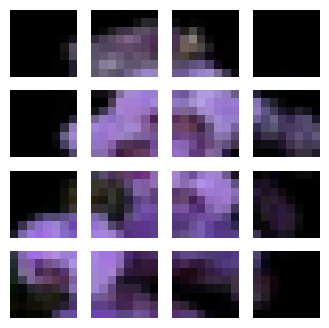

In [6]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

And we get what we'd expect.

## Network Building

We now have some functions to build our network. Here we have:
* A very simple function to stack dense layers
* A layers to do our patch encoding
* A layer for our transformer (taken directly from our previous transformer example)

Perhaps what's worth noting here is that our transformer doesn't actually change. We're using the exact same transformer block that we had before, even through we now have a very different data type. 

In [7]:
# small function to create a simple MLP
def mlp(x, hidden_units, dropout_rate):
    # create dense layers, with a drop-out in between
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# patch encoder layer
class PatchEncoder(layers.Layer):
    # Initialise the layer. This will create the layers that will encode the patches.
    # Params are:
    # - num_patches: the number of patches we're processing
    # - projection_dim: the embedding size for each patch
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        # create a dense layer to project the input with
        self.projection = layers.Dense(units=projection_dim)
        # create the position embedding
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
   
    # Do a forward pass through the encoder
    # params are:
    # - patch: set of patches to process
    def call(self, patch):
        # get the positions of the patches
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # get the encoding, this will be the projection of the patches, pluse the position embedding
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    

# our transformer block
class TransformerBlock(layers.Layer):
    # Initialise the block. This will create all the layers that are used within the transformer block
    # params are:
    # - embed_dim: embedding dimension of the multi-head attention block
    # - num_heads: number of attention heads
    # - ff_dim: output size of the feed forward netowrk
    # - rate: dropout rate (default 0.1)
    #
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention, used to map input to internal representation
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        
        # feed forward network, used to map transformer output to block output
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        
        # layer normalisation blocks, used after attention and feed foward layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # dropout blocks, used after attention and feed foward layer
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Do a forward pass through the block
    # params are:
    # - inputs: what to pass through the network
    # - training: flag to indicate if we are training the model. Use to determine if dropout is on or off
    def call(self, inputs, training = None):
        # pass data through the multi-head attention
        attn_output = self.att(inputs, inputs)
        # dropout applied to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # add attention output to the input and perform normalisation
        out1 = self.layernorm1(inputs + attn_output)
        # pass representation through feed forward network
        ffn_output = self.ffn(out1)
        # apply second dropout
        ffn_output = self.dropout2(ffn_output, training=training)
        # add intermediate representation to the final output, normalise, and return
        return self.layernorm2(out1 + ffn_output)    

Now let's build the actual network using the bits from above.

In [8]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, transformer_units)(encoded_patches)       

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    # Add the MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

vit_classifier = create_vit_classifier()
print(vit_classifier.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)         │          7 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patches_1 (Patches)             │ (None, None, 192)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_encoder (PatchEncoder)    │ (None, 16, 32)            │      6,688 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block               │ (None, 16, 32)            │     21,120 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_1             │ (None, 16, 32)            │     21,120 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer_normalization_4           │ (None, 16, 32)            │         64 │
│ (LayerNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_6 (Dropout)             │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 512)               │    262,656 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_7 (Dropout)             │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_8 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 100)               │     25,700 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 468,683 (1.79 MB)

 Trainable params: 468,676 (1.79 MB)

 Non-trainable params: 7 (32.00 B)

None


Looking at our model, it's not huge in terms of parameters, with a little under 500,000 all up. This is by no means a small model when we think back to what we've had in the past with non-deep learning models, but for a DL model it's fairly compact.

In [9]:
def run_experiment(model):
    # using adam with weight decay, as per the original example
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # we'll get the standard accuracy metric (witch is top-1 accuracy) and also the top-5 accuracy, i.e.
    # how often the correct result is in the top 5 returned classes
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ], jit_compile=False
    )

    # checkpoint saving to grab best model
    checkpoint_file = "vit.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_file,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # fit the model
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
        verbose=False,
    )

    # load the best model model
    model.load_weights(checkpoint_file)

    return history, model

def eval_model(history, model):

    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)
    train_samples = len(x_train)
    test_samples = len(x_test)

    plt.figure(figsize=(10, 6))
    plt.plot(history.history["accuracy"], label="Top-1 Accuracy (Training)")
    plt.plot(history.history["top-5-accuracy"], label="Top-5 Accuracy (Training)")
    plt.plot(history.history["val_accuracy"], label="Top-1 Accuracy (Validation)")
    plt.plot(history.history["val_top-5-accuracy"], label="Top-5 Accuracy (Validation)")
    plt.xlabel('Epoch')
    plt.ylabel('\% Accuracy')
    plt.legend()
    
    cmc_train = []
    cmc_test = []
    rank = []
    for i in range(1,101):
        cmc_train.append(100.0*np.sum(tf.math.in_top_k(y_train[:,0], train_predictions, i))/train_samples)
        cmc_test.append(100.0*np.sum(tf.math.in_top_k(y_test[:,0], test_predictions, i))/test_samples)
        rank.append(i)

    plt.figure(figsize=(10, 6))
    plt.plot(rank, cmc_train, label="Training Data")
    plt.plot(rank, cmc_test, label="Testing Data")
    plt.grid()
    plt.legend()
    plt.xlabel('\% Accuracy')
    plt.ylabel('Rank')

We'll now train the model. Note that to save output

In [10]:
history, model = run_experiment(vit_classifier)

Finally, we can evaluate our model. We see that it works pretty well, and achieves around 40% rank-1 accuracy. Training performance is slightly ahead of the testing data, but not by much.

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


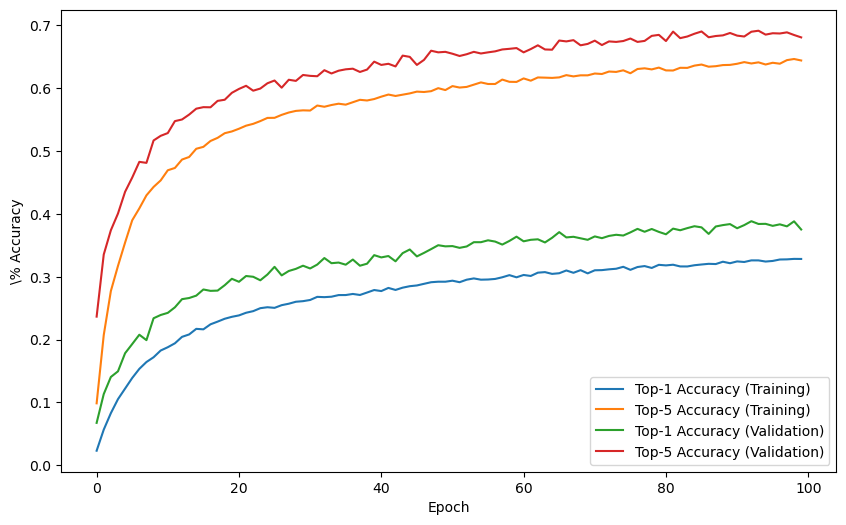

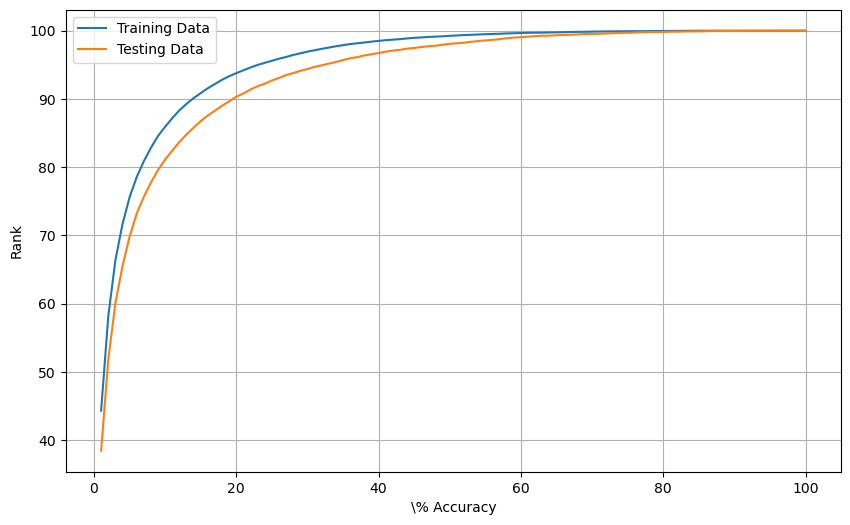

In [11]:
eval_model(history, model)

## Convolutions in our Transformer

We've talked a lot about using convolutions with images due to their ability to capture spatial information. Despite this, our above vision transformer didn't use convolutions. Surely this is sub-optimal? 

We'll now extend the above example, and replace our previous patch encoder with one that uses convolutional layers. This is adapted from [here](https://keras.io/examples/vision/cct/), and some details have been omitted to avoid this example getting too long, and to re-use as much code from above as we possibly can.

In [12]:
conv_layers = 2
projection_dim = 32
conv_channels = [16, 32]
positional_emb = True

### Convolutional Encoder

This is the key bit. Basically, we're going to write a layer that does our encoding using convolutional layers. We've also got a second layer to do the position embeddings for us as well.

In [13]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        # NOTE - tieing this to our projection_dim. Need to have the final output being the same as projection_dim
        num_output_channels=[projection_dim // 2, projection_dim],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = keras.ops.reshape(
            outputs,
            (
                -1,
                keras.ops.shape(outputs)[1] * keras.ops.shape(outputs)[2],
                keras.ops.shape(outputs)[-1],
            ),
        )
        return reshaped
    
class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = keras.ops.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = keras.ops.convert_to_tensor(self.position_embeddings)
        position_embeddings = keras.ops.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return keras.ops.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape    


### Building the Network

Now we can build out network. This part is really the same as above, the only difference is that we replace our patch extractor and patch encoder with the tokeniser that we have directly above this.

In [14]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    sequence_length = encoded_patches.shape[1]
    encoded_patches += PositionEmbedding(sequence_length=sequence_length)(encoded_patches)
        
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, transformer_units)(encoded_patches)

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    # Add the MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

vit_classifier = create_vit_classifier()
print(vit_classifier.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │       7 │ input_layer_4[0][0]  │
│ (Sequential)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ cct_tokenizer       │ (None, 64, 32)    │   5,040 │ data_augmentation[1… │
│ (CCTTokenizer)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ position_embedding  │ (None, 64, 32)    │   2,048 │ cct_tokenizer[0][0]  │
│ (PositionEmbedding) │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add (Add)           │ (None, 64, 32)    │       0 │ cct_tokenizer[0][0], │
│                     │                   │         │ position_embedding[… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ transformer_block_2 │ (None, 64, 32)    │  21,120 │ add[0][0]            │
│ (TransformerBlock)  │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ transformer_block_3 │ (None, 64, 32)    │  21,120 │ transformer_block_2… │
│ (TransformerBlock)  │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ layer_normalizatio… │ (None, 64, 32)    │      64 │ transformer_block_3… │
│ (LayerNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │       0 │ layer_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_15          │ (None, 2048)      │       0 │ flatten_1[0][0]      │
│ (Dropout)           │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │ 1,049,… │ dropout_15[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_16          │ (None, 512)       │       0 │ dense_12[0][0]       │
│ (Dropout)           │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │ 131,328 │ dropout_16[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_17          │ (None, 256)       │       0 │ dense_13[0][0]       │
│ (Dropout)           │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_14 (Dense)    │ (None, 100)       │  25,700 │ dropout_17[0][0]     │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 1,255,515 (4.79 MB)

 Trainable params: 1,255,508 (4.79 MB)

 Non-trainable params: 7 (32.00 B)

None


Comparing this model to our first attempt, we can see that we have over twice the parameters. This doesn't really tell the whole story though. We see that our patch encoder (or tokeniser) for the new network is actually slightly smaller, and the transformers are the exact same size. The difference is that we have 64 tokens rather than 16, which results in our first dense layer after the transformers being much bigger.

We could tweak the parameters of our convolutional encoder to give us 16 embeddings, which would then give us a network of a very similar size to what we started with. As it stands, we'd expect this formulation to do a little better as we'll be better able to capture fine-grained information regarding how regions relate to each other, simply by having more regions to play with.

In [15]:
history, model = run_experiment(vit_classifier)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


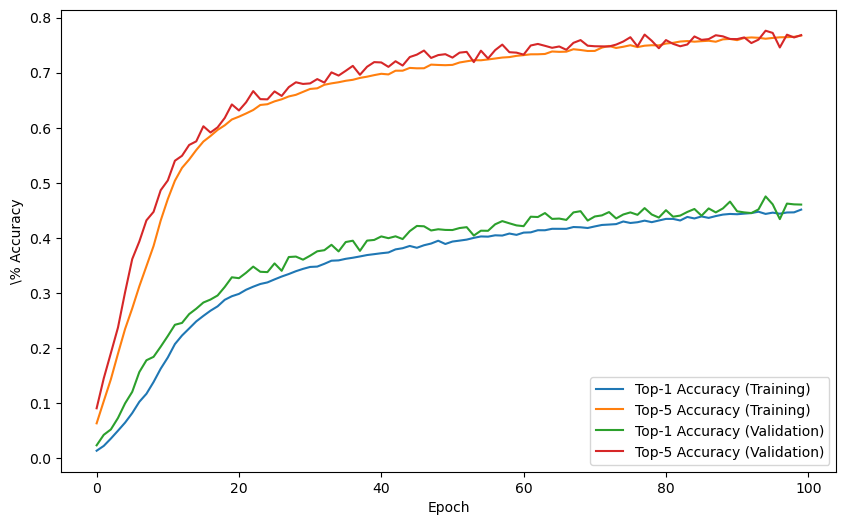

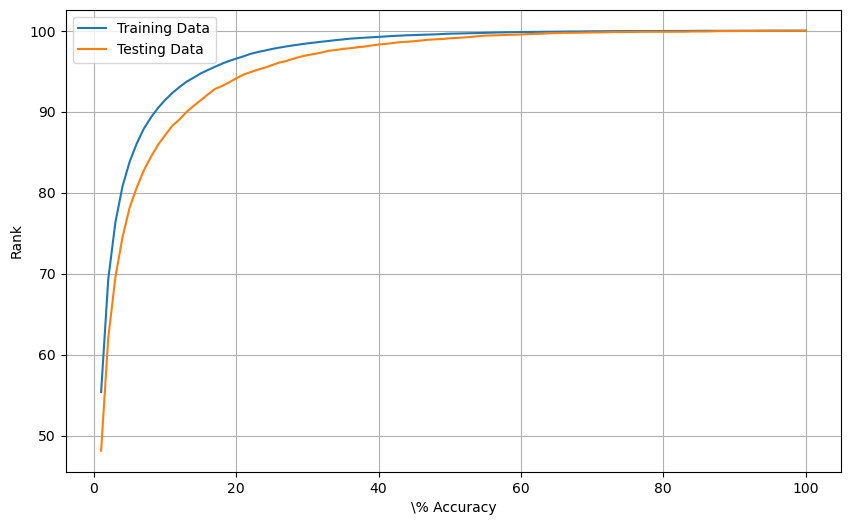

In [16]:
eval_model(history, model)

As we thought may happen, this network gives a nice little performance boost over what we had before, with a roughly 10% rank accuracy increase.

## Final Thoughts

This example has looked at how we can create a visual transformer. Really, we do this in much the same way we do a transformer that operates over text data. The actual transformer block itself doesn't change at all (we've re-used the exact same code), and all that changes is the way that we create the embeddings to go into the transformer.

We've looked at two ways to do this:
* By using a simple dense network applied to patches
* By using convolutional layers to extract features for sub-regions of the image

In both cases we get a set of embeddings that represent some local region of the image. Once we have these, the whole thing proceeds as per usual.

Like we saw for text data, the transform networks are not fast, but they are powerful. The networks we've used here have only used two stacked transformer blocks and quite small embeddings. Bigger embeddings and more transformer blocks will lead to substantial performance gains, but will also be very slow to train.